In [3]:
# ce script fait divers tests de connexion à la base mivisu PCADT de Montpellier 3M pour valider les traitements des données de trafic

import pandas as pd
import matplotlib
import psycopg2

In [4]:
host="demo.grfmap.com"
port=5432
dbname="mivisu"
username="postgres"
pwd="postgres$"

In [5]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from public.tomm_troncons_mesures;"
troncons_mesures = pd.read_sql_query(sql, conn)
conn = None

In [6]:
def mesure_valide_df(id):
    # retourne un dataframe avec la valeur mesurée et l'horodate
    conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
    sql = "select valeur,date_mesure from mivisu.mesure_2 where id_nature_mesure="+str(id)+";"
    df= pd.read_sql_query(sql, conn)
    conn = None
    conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
    sql = "select * from mivisu.validation where id_nature_mesure="+str(id)+";"
    valid= pd.read_sql_query(sql, conn)
    conn = None
    valid=valid[(valid.validite==2) | (valid.validite==4) | (valid.validite==6)]
    # https://stackoverflow.com/questions/56992916/checking-if-any-date-in-a-python-list-of-dates-is-between-two-date-columns
    ix = pd.IntervalIndex.from_arrays(valid['date_debut'],valid['date_fin'],closed='both')
    df['valide']=df.apply(lambda x: ix.contains(x.date_mesure).any(),axis=1)
    return df.reset_index()

In [7]:
# liste des id_nature_mesure QT 1/4h
idQT900=set(troncons_mesures.id_nature_mesure[(troncons_mesures['code_type_mesure']=='QT') & (troncons_mesures['duree_mesure']==900) ])

In [79]:
i=0
for x in list(idQT900):
    i+=1
    if x==36254:
        break
print(i)

1204


In [8]:
list(idQT900)[1204]

36267

In [84]:
idQT900=sorted(list(idQT900))

In [59]:
idQT900[0:9]

[1, 28, 68, 82, 122, 136, 190, 257, 311]

In [9]:
mi=mesure_valide_df(28068)
print ('total:', mi.shape[0],'valides', mi.valide.sum())

total: 676 valides 676


In [10]:
troncons_mesures[troncons_mesures['id_nature_mesure']==28068]

id_canal  id_centrale code_canal  num_ordre     libelle_canal  \
3100      2888          914          0        0.0  Hortensias_Lilas   

      libelle_groupage code_centrale                       libelle_centrale  \
3100  Hortensias_Lilas         48244  MONTPELLIER. Rue du Pere Cyprien Rome   

      type_centrale info_tech  ...                  nom_voie   oneway  \
3100              3            ...  Rue du Père Cyprien Rome  UNKNOWN   

      bicycle  cycles      highway lanes maxspeed_f   ref      commune  \
3100     None    None  residential     0         50  None  Montpellier   

        osm_id  
3100  41991025  

[1 rows x 28 columns]

In [101]:
gid=troncons_mesures.code_centrale.to_list()

In [102]:
gid=sorted(list(set(gid)))

In [106]:
for x in gid:
    if 'B' in x:
        print(x)

In [94]:
# on teste si le débit 1/4h est trop important: ça peut vouloir dire que les mesures contiennent les mesures 1/4H 
# MAIS AUSSI LES MESURES HORAIRES OU JOUR (cas de id_nature_mesure=1)
# cette routine est trop lente
liste_i=[]
for i in idQT900[0:5]:
    mi=mesure_valide_df(i)
    maxi=mi[mi['valide']].valeur.max()
    nbv=troncons_mesures[troncons_mesures['id_nature_mesure']==1].lanes.max() 
    #if nbv==0:
    #    print(i,'0 voies??')
    if maxi>1500*max(nbv,1):
        print (i,maxi)
        print ('total:', mi.shape[0],'valides', mi.valide.sum())
        liste_i.append(i)

1 2395.0
total: 3084 valides 1438


<AxesSubplot:xlabel='heure'>

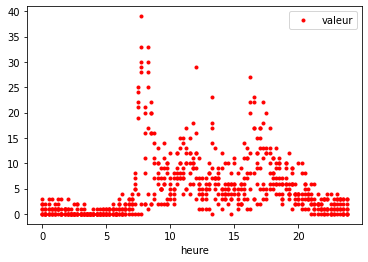

In [11]:
mi['heure']=mi.apply(lambda x: (x.date_mesure.hour*60+x.date_mesure.minute)/60, axis=1)
mi.plot(x='heure',y='valeur', marker='.', color="r", linewidth=0)

In [5]:
m1=mesure_df(27)

In [6]:
m1['heure']=m1.apply(lambda x: (x.date_mesure.hour*60+x.date_mesure.minute)/60, axis=1)

In [10]:
troncons_mesures[troncons_mesures['id_nature_mesure']==3717]

id_canal  id_centrale code_canal  num_ordre  libelle_canal  \
4606      1861           34          0        0.0  Cholet_Valery   

     libelle_groupage code_centrale                         libelle_centrale  \
4606    Cholet_Valery         42210  MONTPELLIER. Avenue du Colonnel Pavelet   

      type_centrale info_tech  ...                   nom_voie  oneway  \
4606             13         Z  ...  Avenue du Colonel Pavelet     YES   

      bicycle  cycles  highway lanes maxspeed_f   ref      commune    osm_id  
4606     None    None  primary     2         50  D 65  Montpellier  81227025  

[1 rows x 28 columns]

In [18]:
troncons_mesures[(troncons_mesures['id_nature_mesure']<30) & (troncons_mesures['id_nature_mesure']>11) ]

id_canal  id_centrale code_canal  num_ordre       libelle_canal  \
22       657          454          1        0.0  Poitiers_Biterrois   
23       657          454          1        0.0  Poitiers_Biterrois   
24       657          454          1        0.0  Poitiers_Biterrois   
25       657          454          1        0.0  Poitiers_Biterrois   
26       657          454          1        0.0  Poitiers_Biterrois   
27       657          454          1        0.0  Poitiers_Biterrois   
28       685          471          0        0.0    Bologne_Lausanne   
29       685          471          0        0.0    Bologne_Lausanne   

      libelle_groupage code_centrale               libelle_centrale  \
22  Poitiers_Biterrois         61543  MONTPELLIER. Rue Daniel Mayer   
23  Poitiers_Biterrois         61543  MONTPELLIER. Rue Daniel Mayer   
24  Poitiers_Biterrois         61543  MONTPELLIER. Rue Daniel Mayer   
25  Poitiers_Biterrois         61543  MONTPELLIER. Rue Daniel Mayer   
26  Poitiers_Biterrois         61543  MONTPELLIER. Rue Daniel Mayer   
27  Poitiers_Biterrois         61543  MONTPELLIER. Rue Daniel Mayer   
28    Bologne_Lausanne        159582      MONTPELLIER. Rue d'Oxford   
29    Bologne_Lausanne        159582      MONTPELLIER. Rue d'Oxford   

    type_centrale info_tech  ...           nom_voie   oneway  bicycle  \
22              3         Z  ...   Rue Daniel Mayer  UNKNOWN     None   
23              3         Z  ...  Boulevard Pasteur      YES     None   
24              3         Z  ...   Rue Daniel Mayer  UNKNOWN     None   
25              3         Z  ...  Boulevard Pasteur      YES     None   
26              3         Z  ...   Rue Daniel Mayer  UNKNOWN     None   
27              3         Z  ...  Boulevard Pasteur      YES     None   
28              3         Z  ...       Rue d'Oxford      YES     None   
29              3         Z  ...       Rue d'Oxford      YES     None   

            cycles      highway lanes maxspeed_f   ref      commune     osm_id  
22            None  residential     0         50  None  Montpellier   97078647  
23            None   pedestrian     0         50  None  Montpellier   23233204  
24            None  residential     0         50  None  Montpellier   97078647  
25            None   pedestrian     0         50  None  Montpellier   23233204  
26            None  residential     0         50  None  Montpellier   97078647  
27            None   pedestrian     0         50  None  Montpellier   23233204  
28  Bande cyclable     tertiary     0         50  None  Montpellier  378155800  
29  Bande cyclable     tertiary     0         50  None  Montpellier  378155800  

[8 rows x 28 columns]

In [10]:
troncons_mesures[['id_centrale','libelle_type_centrale']].groupby(['libelle_type_centrale']).count()

id_centrale
libelle_type_centrale               
Comptage ponctuel              54015
Comptage ponctuel Velos          234
Comptage tournant               4325
Eco-compteurs                    124
Feux Complet                     929
Feux Petrarque 1                 168
Feux Petrarque 2                 406
Stations Rase Campagne          5055
Stations Velos                    50
Stations en Agglo               2962

In [68]:
troncons_mesures[['id_centrale','code_type_mesure']].groupby(['code_type_mesure']).count()

id_centrale
code_type_mesure             
ED                          4
EDF                        29
LC                        900
QL                       2869
QT                       3464
TT                         40
VC                      38800
VT                         42

<AxesSubplot:xlabel='heure'>

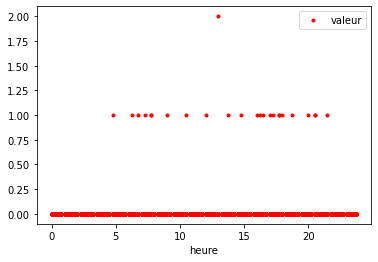

In [58]:
m1.plot(x='heure',y='valeur', marker='.', color="r", linewidth=0)

In [59]:
m1.heure

0       23.50
1       23.75
2        0.00
3        0.25
4        0.50
        ...  
1422     6.50
1423     6.75
1424     7.00
1425     7.25
1426     7.50
Name: heure, Length: 1427, dtype: float64

In [3]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.nature_mesure where duree_mesure=900 and code_type_mesure='QT';"
nature_mesure = pd.read_sql_query(sql, conn)
conn = None


In [4]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.nature_mesure where duree_mesure=3600 and code_type_mesure='QT';"
nature2_mesure = pd.read_sql_query(sql, conn)
conn = None

In [5]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.type_centrale;"
type_centrale = pd.read_sql_query(sql, conn)
conn = None

In [6]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.Centrale;"
centrale = pd.read_sql_query(sql, conn)
conn = None

In [7]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.canal;"
canal = pd.read_sql_query(sql, conn)
conn = None

In [8]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.cal_canal;"
cal_canal = pd.read_sql_query(sql, conn)
conn = None

In [27]:
nature2_mesure

id_nature_mesure code_type_mesure    libelle  duree_mesure  seuil_bas  \
0               53157               QT  Mesure:QT          3600          0   
1               53158               QT  Mesure:QT          3600          0   
2               53159               QT  Mesure:QT          3600          0   
3               53164               QT  Mesure:QT          3600          0   
4               53203               QT  Mesure:QT          3600          0   
..                ...              ...        ...           ...        ...   
539             64483               QT  Mesure:QT          3600          0   
540             64484               QT  Mesure:QT          3600          0   
541             64485               QT  Mesure:QT          3600          0   
542             64486               QT  Mesure:QT          3600          0   
543             64758               QT  Mesure:QT          3600          0   

     seuil_haut loc_libelle  format unite origine classe  dur_blob  \
0             0       Lieu?       1     ?           0000         0   
1             0       Lieu?       1     ?           0000         0   
2             0       Lieu?       1     ?           0000         0   
3             0       Lieu?       1     ?           0000         0   
4             0       Lieu?       1     ?           0000         0   
..          ...         ...     ...   ...     ...    ...       ...   
539           0       Lieu?       1     ?           0000         0   
540           0       Lieu?       1     ?           0000         0   
541           0       Lieu?       1     ?           0000         0   
542           0       Lieu?       1     ?           0000         0   
543           0       Lieu?       1     ?           0000         0   

     sens_mesure       date_creation   date_modification  
0              1 2020-05-25 13:42:07 2020-05-25 13:42:07  
1              1 2020-05-25 13:43:27 2020-05-25 13:43:27  
2              1 2020-05-25 13:44:44 2020-05-25 13:44:44  
3              1 2020-05-25 18:13:08 2020-05-25 18:13:08  
4              1 2020-05-27 16:43:19 2020-05-27 16:43:19  
..           ...                 ...                 ...  
539            1 2022-01-28 16:03:24 2022-01-28 16:03:24  
540            1 2022-01-28 16:03:27 2022-01-28 16:03:27  
541            1 2022-02-10 11:14:10 2022-02-10 11:14:10  
542            1 2022-02-10 11:14:14 2022-02-10 11:14:14  
543            1 2022-03-08 10:33:42 2022-03-08 10:33:42  

[544 rows x 15 columns]

In [28]:
# y a-t-il les mêmes type_centrale dans les tables type_centrale et centrale ?
type_centrale_c=set(centrale.type)
type_centrale_tc=set(type_centrale.id_type_centrale)

In [34]:
print(type_centrale_c-type_centrale_tc) # la table centrale contient une de type_centrale -1 !
print(centrale[centrale['type']==-1]) # id_centrale 1392 RD610 à Castries
print(type_centrale_tc-type_centrale_c)
# la table centrale ne contient pas les type_centrale >1 (feux pétrarque) et 2 (station de comptage) !

{-1}
      id_centrale code_centrale          libelle  type info_tech
1278         1392        190974  CASTRIES. RD610    -1          
{1, 2}


In [13]:
# y a-t-il les mêmes id_centrales dans canal et dans centrale?
canal_id_centrale=set(list(canal.id_centrale))
centrale_id_centrale=set(list(centrale.id_centrale))

In [16]:
print(canal_id_centrale-centrale_id_centrale) #0
print(centrale_id_centrale-canal_id_centrale) #0
print(len(centrale_id_centrale.intersection(canal_id_centrale)))
# oui les mêmes 1713 valeurs de id_centrale dans les 2 tables

set()
set()
1713


In [37]:
# y a-t-il les mêmes id canal dans canal et dans centrale?
id_canal_canal=set(list(canal.id_canal))
id_canal_cal=set(list(cal_canal.id_canal))
print(len(id_canal_canal-id_canal_cal)) #102 id_canal sont dans la table canal mais pas dans la table cal_canal
print(len(id_canal_cal-id_canal_canal)) #0
print(len(id_canal_canal.intersection(id_canal_cal))) #3091 id_canal communs aux 2 tables

102
0
3091


In [38]:
# y a-t-il les mêmes id nature_mesure dans nature_mesure et dans cal_canal?
nature_mesure_nm=set(list(nature_mesure.id_nature_mesure))
nature_mesure_cal=set(list(cal_canal.id_nature_mesure))
print(len(nature_mesure_cal-nature_mesure_nm)) #45087 id_nature_mesure sont dans la table cal_canal mais PAS dans la table nature_mesure!
# ça semble surtout être des mesures de longueur et des débits/vitesses classifiés??
print(len(nature_mesure_nm-nature_mesure_cal)) #0
print(len(nature_mesure_nm.intersection(nature_mesure_cal))) #2839 id_nature_mesure sont communs aux 2 tables

45087
0
2839


In [47]:
cal_canal[cal_canal['id_nature_mesure'].isin(nature_mesure_cal-nature_mesure_nm)]

id_cal_canal  id_nature_mesure  id_canal             libelle  \
1                 2                 2       657  affectation:VC-900   
2                 3                 3       657  affectation:VC-900   
3                 4                 4       657  affectation:VC-900   
4                 5                 5       657  affectation:VC-900   
5                 6                 6       657  affectation:VC-900   
...             ...               ...       ...                 ...   
47934         65258             65268     40579  affectation:VC-900   
47935         65259             65269     40579  affectation:VC-900   
47936         65260             65270     40579  affectation:VC-900   
47937         65261             65271     40578  affectation:QL-900   
47938         65262             65272     40579  affectation:QL-900   

      date_debut   date_fin  
1     1980-01-01 2030-01-01  
2     1980-01-01 2030-01-01  
3     1980-01-01 2030-01-01  
4     1980-01-01 2030-01-01  
5     1980-01-01 2030-01-01  
...          ...        ...  
47934 1980-01-01 2030-01-01  
47935 1980-01-01 2030-01-01  
47936 1980-01-01 2030-01-01  
47937 1980-01-01 2030-01-01  
47938 1980-01-01 2030-01-01  

[45100 rows x 6 columns]

In [9]:
cal_canal[cal_canal.id_nature_mesure==1]

id_cal_canal  id_nature_mesure  id_canal             libelle date_debut  \
0             1                 1       657  affectation:QT-900 1980-01-01   

    date_fin  
0 2030-01-01

In [10]:
canal[canal.id_canal==657]

id_canal  id_centrale code_canal  num_ordre       libelle_canal  \
1240       657          454          1        0.0  Poitiers_Biterrois   

        libelle_groupage  
1240  Poitiers_Biterrois

In [11]:
centrale[centrale.id_centrale==454]

id_centrale code_centrale                        libelle  type info_tech
785          454         61543  MONTPELLIER. Rue Daniel Mayer     3         Z

In [12]:
type_centrale[type_centrale.id_type_centrale==3]

id_type_centrale            libelle  type
11                 3  Comptage ponctuel     0

In [47]:
centrale

id_centrale code_centrale                                libelle  type  \
0            1543         21212   MONTPELLIER. Avenue du comte de nice     3   
1             695         49253  MONTPELLIER. Rue du Faubourg de Nimes     3   
2               5        135806          RM017 PRADES LE LEZ - MMT34.b     7   
3               4        144284              RM613 FABREGUES - MMT34.W     7   
4             671        141560    MONTPELLIER. Rue de la Roqueturiere     3   
...           ...           ...                                    ...   ...   
1708         1913          1576           MONTPELLIER. Rue Coste Frege     3   
1709         1914          5625            MONTPELLIER. Rue de l'Oasis     3   
1710         1915         12147             MONTPELLIER. Rue de l'Onyx     3   
1711         1916         49598         MONTPELLIER. Rue Rene Etiemble     3   
1712         1917         41785        MONTPELLIER. Rue Viollet le Duc     3   

     info_tech  
0               
1               
2            Z  
3            Z  
4               
...        ...  
1708            
1709            
1710            
1711            
1712            

[1713 rows x 5 columns]

In [29]:
nature_mesure

id_nature_mesure code_type_mesure    libelle  duree_mesure  seuil_bas  \
0                    1               QT  Mesure:QT           900          0   
1                   28               QT  Mesure:QT           900          0   
2                   68               QT  Mesure:QT           900          0   
3                   82               QT  Mesure:QT           900          0   
4                  122               QT  Mesure:QT           900          0   
...                ...              ...        ...           ...        ...   
2834             65164               QT  Mesure:QT           900          0   
2835             65179               QT  Mesure:QT           900          0   
2836             65193               QT  Mesure:QT           900          0   
2837             65245               QT  Mesure:QT           900          0   
2838             65258               QT  Mesure:QT           900          0   

      seuil_haut loc_libelle  format unite origine classe  dur_blob  \
0              0       Lieu?       1     ?           0000         0   
1              0       Lieu?       1     ?           0000         0   
2              0       Lieu?       1     ?           0000         0   
3              0       Lieu?       1     ?           0000         0   
4              0       Lieu?       1     ?           0000         0   
...          ...         ...     ...   ...     ...    ...       ...   
2834           0       Lieu?       1     ?           0000         0   
2835           0       Lieu?       1     ?           0000         0   
2836           0       Lieu?       1     ?           0000         0   
2837           0       Lieu?       1     ?           0000         0   
2838           0       Lieu?       1     ?           0000         0   

      sens_mesure       date_creation   date_modification  
0               1 2016-12-09 13:06:01 2016-12-09 13:06:01  
1               1 2016-12-09 13:08:01 2016-12-09 13:08:01  
2               1 2016-12-09 13:12:40 2016-12-09 13:12:40  
3               1 2016-12-09 13:13:22 2016-12-09 13:13:22  
4               1 2016-12-09 13:16:02 2016-12-09 13:16:02  
...           ...                 ...                 ...  
2834            1 2022-03-18 08:02:47 2022-03-18 08:02:47  
2835            1 2022-03-18 16:00:55 2022-03-18 16:00:55  
2836            1 2022-03-18 16:07:34 2022-03-18 16:07:34  
2837            1 2022-03-22 15:42:58 2022-03-22 15:42:58  
2838            1 2022-03-22 15:44:21 2022-03-22 15:44:21  

[2839 rows x 15 columns]

In [15]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from mivisu.mesure_2 where id_nature_mesure=122 ORDER BY valeur DESC;"
hmvl = pd.read_sql_query(sql, conn)
conn = None


In [14]:
hmvl.columns

Index(['id_nature_mesure', 'date_mesure', 'valeur'], dtype='object')

In [29]:
hmvl

id_nature_mesure         date_mesure  valeur
0                 53157 2020-03-09 08:00:00  1025.0
1                 53157 2019-10-01 08:00:00  1024.0
2                 53157 2020-01-20 08:00:00  1012.0
3                 53157 2019-02-21 08:00:00  1011.0
4                 53157 2020-02-25 08:00:00  1007.0
...                 ...                 ...     ...
27406             53157 2021-02-21 07:00:00     0.0
27407             53157 2021-02-21 09:00:00     0.0
27408             53157 2021-07-01 01:00:00     0.0
27409             53157 2020-03-29 03:00:00     0.0
27410             53157 2021-02-21 08:00:00     0.0

[27411 rows x 3 columns]

In [32]:
hmvl.date_mesure.dt.minute.sum()

36447

In [13]:
from matplotlib import pyplot


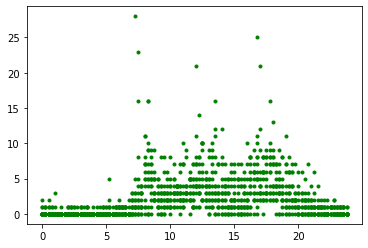

In [16]:
pyplot.plot((hmvl.date_mesure.dt.hour*60+hmvl.date_mesure.dt.minute)/60,hmvl.valeur,'g.')

In [5]:
# EXPORT DE LA TABLE TOMM_CENTRALE
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from public.tomm_centrale;"
tomm_centrale = pd.read_sql_query(sql, conn)
conn = None

In [7]:
tomm_centrale.to_csv(f"../3Mdata/tomm_centrale.csv", index=False)